<a href="https://colab.research.google.com/github/Sahel-Eskandar/ML-Calibration/blob/main/ML_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Calibration

In [13]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, log_loss

# Load the "mnist_784" dataset (a subset will be used for faster execution)
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target']

# Use a subset of the dataset for faster execution
X = X[:10000]
y = y[:10000]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the classifier without calibration
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)
print("Accuracy without calibration:", accuracy_score(y_test, y_pred))
print("Log loss without calibration:", log_loss(y_test, y_pred_proba))

# Calibrate the classifier using isotonic regression
calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
calibrated_rf.fit(X_train, y_train)

# Evaluate the calibrated classifier
y_pred_calibrated = calibrated_rf.predict(X_test)
y_pred_proba_calibrated = calibrated_rf.predict_proba(X_test)
print("Accuracy with calibration:", accuracy_score(y_test, y_pred_calibrated))
print("Log loss with calibration:", log_loss(y_test, y_pred_proba_calibrated))

# Binarize the true labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Calculate the Brier score for each class
brier_scores = [
    brier_score_loss(y_test_binarized[:, i], y_pred_proba_calibrated[:, i])
    for i in range(y_test_binarized.shape[1])
]

# Calculate the average Brier score across all classes
average_brier_score = np.mean(brier_scores)

print(f"Average Brier score across all classes: {average_brier_score:.4f}")

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Accuracy without calibration: 0.9495
Log loss without calibration: 0.37637322941353757
Accuracy with calibration: 0.9525
Log loss with calibration: 0.18414947220067412
Average Brier score across all classes: 0.0075


In [ ]:
# Evaluate the classifier without calibration
y_pred = rf.predict(X_test)
print("Accuracy without calibration:", accuracy_score(y_test, y_pred))
print("Classification report without calibration:")
print(classification_report(y_test, y_pred, digits=4))

# Evaluate the calibrated classifier
y_pred_calibrated = calibrated_rf.predict(X_test)
print("Accuracy with calibration:", accuracy_score(y_test, y_pred_calibrated))
print("Classification report with calibration:")
print(classification_report(y_test, y_pred_calibrated, digits=4))

Accuracy without calibration: 0.9495
Classification report without calibration:
              precision    recall  f1-score   support

           0     0.9537    0.9952    0.9740       207
           1     0.9638    0.9861    0.9748       216
           2     0.9455    0.9363    0.9409       204
           3     0.8980    0.9167    0.9072       192
           4     0.9706    0.9384    0.9542       211
           5     0.9636    0.9034    0.9326       176
           6     0.9772    0.9727    0.9749       220
           7     0.9417    0.9722    0.9567       216
           8     0.9341    0.9398    0.9369       166
           9     0.9412    0.9167    0.9288       192

    accuracy                         0.9495      2000
   macro avg     0.9489    0.9477    0.9481      2000
weighted avg     0.9497    0.9495    0.9494      2000

Accuracy with calibration: 0.9525
Classification report with calibration:
              precision    recall  f1-score   support

           0     0.9624    0.990

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss

# Create synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
base_classifier = SVC(kernel='linear', C=1, probability=True)
base_classifier.fit(X_train, y_train)

# Get predicted probabilities
y_pred_probs = base_classifier.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_base = brier_score_loss(y_test, y_pred_probs)
print(f"Brier score of base classifier: {brier_base:.4f}")


Brier score of base classifier: 0.1090


#Platt Scaling

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

# Calibrate using Platt Scaling
platt_calibrator = CalibratedClassifierCV(base_classifier, method='sigmoid', cv='prefit')
platt_calibrator.fit(X_train, y_train)

# Get Platt calibrated probabilities
y_pred_probs_platt = platt_calibrator.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_platt = brier_score_loss(y_test, y_pred_probs_platt)
print(f"Brier score after Platt Scaling: {brier_platt:.4f}")


Brier score after Platt Scaling: 0.1091


<Figure size 770x770 with 0 Axes>

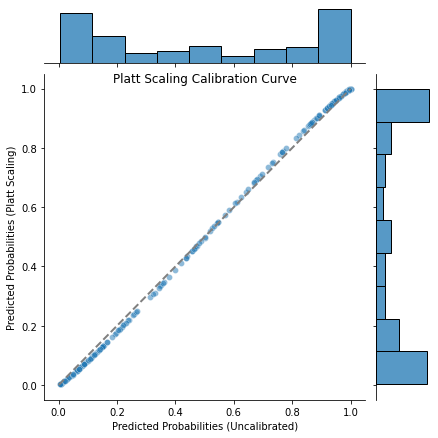

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_platt, alpha=0.5,color='#1f77b4')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Platt Scaling)')
plt.title('Platt Scaling Calibration Curve', y=1.0, pad=-8)
plt.show()

#Isotonic Regression

In [ ]:
# Calibrate using Isotonic Regression
isotonic_calibrator = CalibratedClassifierCV(base_classifier, method='isotonic', cv='prefit')
isotonic_calibrator.fit(X_train, y_train)

# Get isotonic calibrated probabilities
y_pred_probs_isotonic = isotonic_calibrator.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_isotonic = brier_score_loss(y_test, y_pred_probs_isotonic)
print(f"Brier score after Isotonic Regression: {brier_isotonic:.4f}")


Brier score after Isotonic Regression: 0.1071


<Figure size 770x770 with 0 Axes>

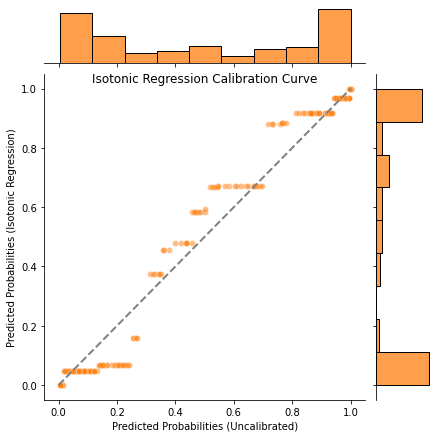

In [67]:
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_isotonic, alpha=0.5,color='#ff7f0e') 
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Isotonic Regression)')
plt.title('Isotonic Regression Calibration Curve', y=1.0, pad=-8)
plt.show()

#Temperature Scaling

In [ ]:
from scipy.optimize import minimize_scalar
from sklearn.metrics import log_loss

def temperature_scaling(logits, y_true, t_init=1.0, max_iter=50, tol=1e-6):
    def nll(t, logits, y_true):
        temp_logits = np.clip(logits, -1e2, 1e2) / t
        temp_probs = np.exp(temp_logits) / (1 + np.exp(temp_logits))
        return -np.mean(y_true * np.log(temp_probs) + (1 - y_true) * np.log(1 - temp_probs))

    result = minimize_scalar(nll, bounds=(0, 10), args=(logits, y_true), method='bounded', options={'maxiter': max_iter, 'xatol': tol})
    t = result.x
    return logits / t
# Get logits for the test set
logits = base_classifier.decision_function(X_test)

# Calibrate using Temperature Scaling
logits_temp_scaled = temperature_scaling(logits, y_test)
y_pred_probs_temp_scaled = np.exp(logits_temp_scaled) / (1 + np.exp(logits_temp_scaled))

# Evaluate Brier score
brier_temp_scaled = brier_score_loss(y_test, y_pred_probs_temp_scaled)
print(f"Brier score after Temperature Scaling: {brier_temp_scaled:.4f}")



Brier score after Temperature Scaling: 0.1087


<Figure size 770x770 with 0 Axes>

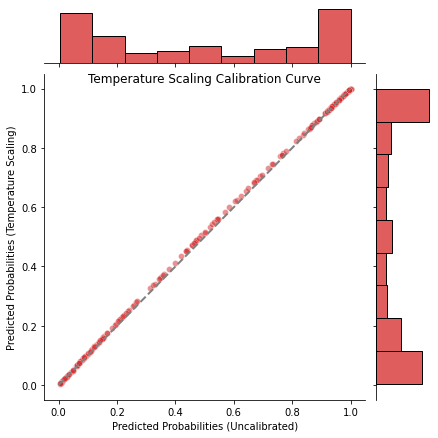

In [68]:
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_temp_scaled, alpha=0.5,color='#d62728' )
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Temperature Scaling)')
plt.title('Temperature Scaling Calibration Curve', y=1.0, pad=-8)
plt.show()

#Bayesian Binning into Quantiles (BBQ)

In [ ]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss
from scipy.stats import beta

# Create synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
base_classifier = SVC(kernel='linear', C=1, probability=True)
base_classifier.fit(X_train, y_train)

# Get predicted probabilities
y_pred_probs = base_classifier.predict_proba(X_test)[:, 1]

def bbq_calibration(y_true, y_pred_probs, n_bins=10):
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_pred_probs, bin_edges) - 1
    bin_true_probs = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = bin_indices == i
        bin_true_probs[i] = np.mean(y_true[mask]) if np.sum(mask) > 0 else 0.5

    return bin_true_probs[bin_indices]

# Calibrate using Bayesian Binning into Quantiles (BBQ)
y_pred_probs_bbq = bbq_calibration(y_test, y_pred_probs)

# Evaluate Brier score
brier_bbq = brier_score_loss(y_test, y_pred_probs_bbq)
print(f"Brier score after Bayesian Binning into Quantiles (BBQ): {brier_bbq:.4f}")


Brier score after Bayesian Binning into Quantiles (BBQ): 0.0979


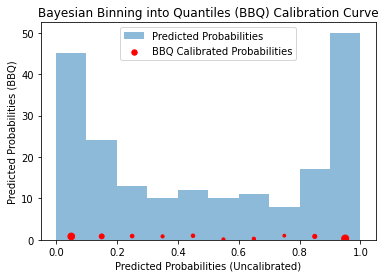

In [ ]:
n_bins = 10
bin_edges = np.linspace(0, 1, n_bins + 1)
bin_indices = np.digitize(y_pred_probs, bin_edges) - 1
bin_counts, _, _ = plt.hist(y_pred_probs, bins=bin_edges, alpha=0.5, label='Predicted Probabilities')

plt.scatter((bin_edges[:-1] + bin_edges[1:]) / 2, y_pred_probs_bbq[np.unique(bin_indices)],
            s=bin_counts, c='red', marker='o', label='BBQ Calibrated Probabilities')
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (BBQ)')
plt.title('Bayesian Binning into Quantiles (BBQ) Calibration Curve')
plt.legend()
plt.show()


<Figure size 770x770 with 0 Axes>

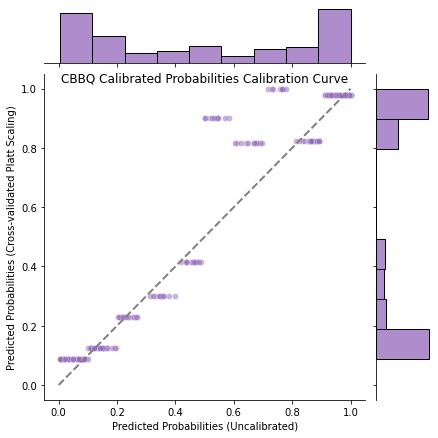

In [69]:
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_bbq, alpha=0.5,color='#9467bd')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Cross-validated Platt Scaling)')
plt.title('CBBQ Calibrated Probabilities Calibration Curve', y=1.0, pad=-8)
plt.show()

#Cross-validated Platt Scaling

In [ ]:
# Calibrate using cross-validated Platt Scaling
platt_calibrator_cv = CalibratedClassifierCV(base_classifier, method='sigmoid', cv=5)
platt_calibrator_cv.fit(X_train, y_train)

# Get cross-validated Platt calibrated probabilities
y_pred_probs_platt_cv = platt_calibrator_cv.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_platt_cv = brier_score_loss(y_test, y_pred_probs_platt_cv)
print(f"Brier score after cross-validated Platt Scaling: {brier_platt_cv:.4f}")


Brier score after cross-validated Platt Scaling: 0.1094


<Figure size 770x770 with 0 Axes>

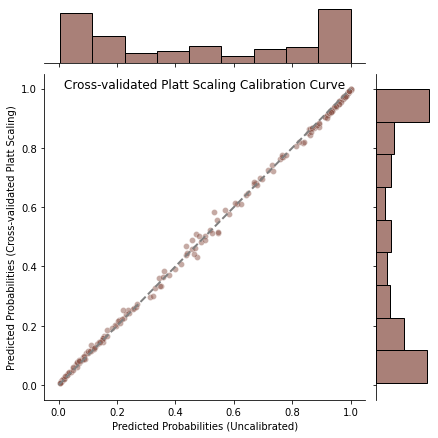

In [70]:
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_platt_cv, alpha=0.5,color= '#8c564b')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Cross-validated Platt Scaling)')
plt.title('Cross-validated Platt Scaling Calibration Curve', y=1.0, pad=-14)
plt.show()

#RandomForest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForest classifier
ensemble_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
ensemble_classifier.fit(X_train, y_train)

# Get predicted probabilities
y_pred_probs_ensemble = ensemble_classifier.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_ensemble = brier_score_loss(y_test, y_pred_probs_ensemble)
print(f"Brier score of ensemble classifier: {brier_ensemble:.4f}")


Brier score of ensemble classifier: 0.0936


<Figure size 770x770 with 0 Axes>

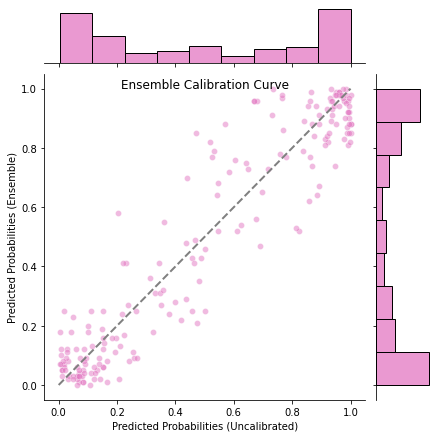

In [71]:
import seaborn as sns
plt.figure(figsize=(7,7),dpi=110)
sns.jointplot(x=y_pred_probs, y=y_pred_probs_ensemble, alpha=0.5,color='#e377c2')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Ensemble)')
plt.title('Ensemble Calibration Curve', y=1.0, pad=-14)
plt.show()

#Cost-sensitive classifier

In [ ]:
from sklearn.svm import SVC

# Define a custom cost matrix
cost_matrix = np.array([[0, 1.5],  # [0, 1] cost
                        [1, 0]])   # [1, 0] cost

# Train a cost-sensitive SVM classifier
cs_svm = SVC(kernel='linear', C=1, class_weight={0: cost_matrix[0, 1], 1: cost_matrix[1, 0]}, probability=True)
cs_svm.fit(X_train, y_train)

# Get predicted probabilities
y_pred_probs_cs = cs_svm.predict_proba(X_test)[:, 1]

# Evaluate Brier score
brier_cs = brier_score_loss(y_test, y_pred_probs_cs)
print(f"Brier score of cost-sensitive classifier: {brier_cs:.4f}")


Brier score of cost-sensitive classifier: 0.1103


<Figure size 504x504 with 0 Axes>

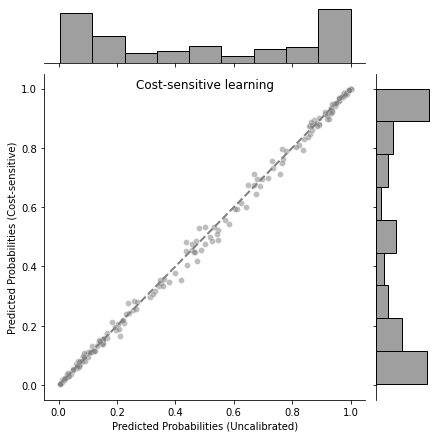

In [73]:
plt.figure(figsize=(7,7))
sns.jointplot(x = y_pred_probs, y = y_pred_probs_cs, alpha=0.5,color='#7f7f7f')
plt.plot([0, 1], [0, 1], '--', color='gray', linewidth=2)
plt.xlabel('Predicted Probabilities (Uncalibrated)')
plt.ylabel('Predicted Probabilities (Cost-sensitive)')
plt.title('Cost-sensitive learning', y=1.0, pad=-14)
plt.show()

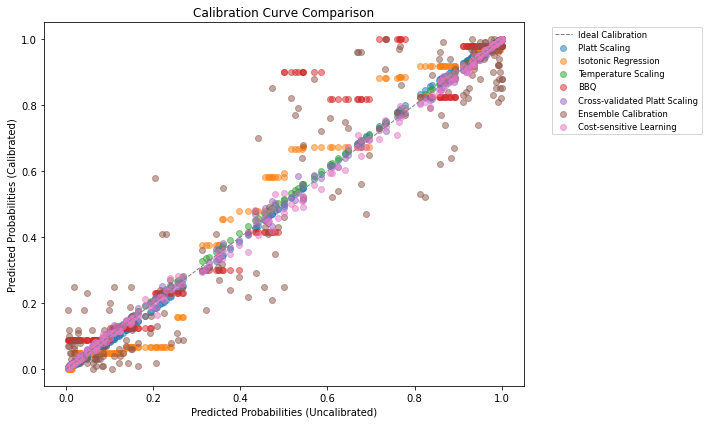

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original uncalibrated probabilities
ax.plot([0, 1], [0, 1], '--', color='gray', linewidth=1, label='Ideal Calibration')

# Plot the calibration curves for each method
ax.scatter(y_pred_probs, y_pred_probs_platt, alpha=0.5, label='Platt Scaling')
ax.scatter(y_pred_probs, y_pred_probs_isotonic, alpha=0.5, label='Isotonic Regression')
ax.scatter(y_pred_probs, y_pred_probs_temp_scaled, alpha=0.5, label='Temperature Scaling')
ax.scatter(y_pred_probs, y_pred_probs_bbq, alpha=0.5, label='BBQ')
ax.scatter(y_pred_probs, y_pred_probs_platt_cv, alpha=0.5, label='Cross-validated Platt Scaling')
ax.scatter(y_pred_probs, y_pred_probs_ensemble, alpha=0.5, label='Ensemble Calibration')
ax.scatter(y_pred_probs, y_pred_probs_cs, alpha=0.5, label='Cost-sensitive Learning')

# Set axis labels, title, and legend
ax.set_xlabel('Predicted Probabilities (Uncalibrated)')
ax.set_ylabel('Predicted Probabilities (Calibrated)')
ax.set_title('Calibration Curve Comparison')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.graph_objects as go

In [ ]:
# Create a scatter plot with an ideal calibration curve
fig = go.Figure(go.Scatter(x=[0, 1], y=[0, 1], 
                           mode='lines', 
                           line=dict(dash='dash', color='gray'), 
                           name='Ideal Calibration'))

colors_list = ['#1f77b4',  # muted blue
               '#ff7f0e',  # safety orange
               '#d62728',  # brick red
               '#9467bd',  # muted purple
               '#8c564b',  # chestnut brown
               '#e377c2',  # raspberry yogurt pink
               '#7f7f7f',  # middle gray
               '#bcbd22',  # curry yellow-green
               '#17becf'  # blue-teal
                ]
# Add the calibration curve for each method as invisible traces
methods = [('Platt Scaling', y_pred_probs_platt),
           ('Isotonic Regression', y_pred_probs_isotonic),
           ('Temperature Scaling', y_pred_probs_temp_scaled),
           ('BBQ', y_pred_probs_bbq),
           ('Cross-validated Platt Scaling', y_pred_probs_platt_cv),
           ('Ensemble Calibration', y_pred_probs_ensemble),
           ('Cost-sensitive Learning', y_pred_probs_cs)
           ]
L = len(methods)

#for method, y_pred_probs_calibrated in methods:


# Define the dropdown menu
dropdown_menu = [
    {
        "args": [{"visible": [False] * L, "showlegend": [False] * L}],
        "label": "Select Method",
        "method": "update",
    }
]

for idx, (method, y_pred_probs_calibrated) in enumerate(methods):
    fig.add_trace(go.Scatter(x=y_pred_probs, y=y_pred_probs_calibrated, 
                             mode='markers', 
                             marker=dict(size=6, color=colors_list[idx],opacity=0.5),
                             name=method, 
                             visible=False))
    visible_list = [False] * L
    visible_list[(idx+1)%L] = True
    showlegend_list = [False] * L
    showlegend_list[(idx+1)%L] = True
    dropdown_menu.append(
        {
            "args": [
                {
                    "visible": visible_list,
                    "showlegend": showlegend_list,
                    "annotations": [
                        {
                            "text": method,
                            "showarrow": False,
                            "xref": "paper",
                            "yref": "paper",
                            "x": 1,
                            "y": 1,
                            "xanchor": "right",
                            "yanchor": "bottom",
                            "font": {"size": 16},
                        },
                        {
                            "text": "Ideal Calibration",
                            "showarrow": False,
                            "xref": "paper",
                            "yref": "paper",
                            "x": 1,
                            "y": 1,
                            "xanchor": "right",
                            "yanchor": "bottom",
                            "font":{"size": 16},
                        }
                    ],
                }
            ],
            "label": method,
            "method": "update",
        }
    )

fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            buttons=dropdown_menu,
            showactive=False,
            direction="down",
            pad={"r": 10, "t": 10},
            x=0.05,
            xanchor="left",
            y=1.15,
            yanchor="top",
        )
    ]
)

# Add axis labels
fig.update_xaxes(title_text="Predicted Probabilities (Uncalibrated)")
fig.update_yaxes(title_text="Predicted Probabilities (Calibrated)")

# Show the interactive plot
fig.show()